# BATTLE OF NEIGHBORHOOD (week 5) 

## <font color=green>_The Delhi Perspective_</font>

In [1]:
%%html
<img src ="img/python1.jpg",height=500,width=600>

# 1. INTRODUCTION

Delhi is the capital city of India and is known as the "Heart Of The Nation". It has a population of 11 million and metropolitan population of 16.3 million. This makes city the second most populous city in India.It covers an area of 573 square miles (1,480 km2) And Speaking about the variety of cuisines, One can easily get all variety of food items which will definitely follow their taste; all you have to do is to find out the right place. From a historic restaurant to a modernly outlined place serving the best food items are easy to find in India’s Capital Territory

### 1.1  Business Problem and Discussion of Background
With such huge population and people from all of the country of different culture, one find its difficult to decide as where to open a restaurant.

In the Delhi Perspective, we will try to find out some of the issues listed below:
-  Which areas are more populated.
-  Comparing the different areas of delhi.
-  The most Suitable location of having Restaurant.
-  The area which has the maximum number of restaurants.


### 1.2  Beneficiaries
- All the Businessmen who are ready to invest their money in opening restaurant.
- All the general public and the tourists who wants to change their taste and try out different cuisines.
- The jobseekers who can easily find out the work in the busiest areas of Delhi.
- The Marketing people who can have their big impact on public using the information after comparing cities.

# 2. DATA

We will be using data as per:

1. Web scraping data from wikipedia of districts of delhi.
2. Web scraping data from other websites of delhi having population in it.
3. Using Geocoder package to get the latitudes and longitudes.
4. Using FourSquare location to fetch the details of venues nearby.

### 2.1 Data Collection

#### Import libraries:

In [2]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import seaborn as sns # for visualization
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# import the Geocoder
import geocoder

# import time
import time

import folium # map rendering library
print('folium imported...')
print('...Done')


numpy, pandas, ..., imported...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
folium imported...
...Done


In [3]:
# obtaining the link from website
link=("https://www.census2011.co.in/census/state/districtlist/delhi.html")
page = requests.get(link)
page

<Response [200]>

In [4]:
# cleans the html file
soup = BeautifulSoup(page.content, 'html.parser')
## This extracts the table from within the page.
my_table=soup.find("table")

In [5]:
# Extracts all "tr" (table rows) within the table above
rows=my_table.find_all("tr")

In [6]:
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')for i in rows[0].find_all("th")]
columns

['#',
 'District',
 'Sub-Districts',
 'Population',
 'Increase',
 'Sex Ratio',
 'Literacy',
 'Density']

In [7]:
# Extracts every row with corresponding columns and creating a dataframe
l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
del l[0]
df=pd.DataFrame(l, columns= columns,index=None)
df

,#,District,Sub-Districts,Population,Increase,Sex Ratio,Literacy,Density
0,1,North West Delhi,List,"3,656,539",27.81 %,865,84.45 %,8254
1,2,South Delhi,List,"2,731,929",20.51 %,862,86.57 %,11060
2,3,West Delhi,List,"2,543,243",19.46 %,875,86.98 %,19563
3,4,South West Delhi,List,"2,292,958",30.65 %,840,88.28 %,5446
4,5,North East Delhi,List,"2,241,624",26.78 %,886,83.09 %,36155
5,6,East Delhi,List,"1,709,346",16.79 %,884,89.31 %,27132
6,7,North Delhi,List,"887,978",13.62 %,869,86.85 %,14557
7,\n\n\n (adsbygoogle = window.adsbygoogle |...,None,None,None,None,None,None,None
8,8,Central Delhi,List,"582,320",-9.91 %,892,85.14 %,27730
9,9,New Delhi,List,"142,004",-20.72 %,822,88.34 %,4057


In [8]:
# The Sub-Districts  and # column doesnot contains any information , we will drop it.
df.drop(["#","Sub-Districts"],axis=1,inplace=True)
# Remove the row containing none
df = df.dropna(how='any',axis=0) 
df

,District,Population,Increase,Sex Ratio,Literacy,Density
0,North West Delhi,"3,656,539",27.81 %,865,84.45 %,8254
1,South Delhi,"2,731,929",20.51 %,862,86.57 %,11060
2,West Delhi,"2,543,243",19.46 %,875,86.98 %,19563
3,South West Delhi,"2,292,958",30.65 %,840,88.28 %,5446
4,North East Delhi,"2,241,624",26.78 %,886,83.09 %,36155
5,East Delhi,"1,709,346",16.79 %,884,89.31 %,27132
6,North Delhi,"887,978",13.62 %,869,86.85 %,14557
8,Central Delhi,"582,320",-9.91 %,892,85.14 %,27730
9,New Delhi,"142,004",-20.72 %,822,88.34 %,4057


### Lets get the Headquarters or subdistricts of Delhi using data by web scraping 

In [9]:
link=("https://en.wikipedia.org/wiki/List_of_districts_of_Delhi")
wikipedia_page = requests.get(link)
# Cleans html file
soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
# This extracts the table where class is "wikitable"
table = soup.find('table', {'class':'wikitable'})
# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns1 = [i.text.replace('\n', '')for i in rows[0].find_all("th")]
columns1

['Sl.No.', 'District', 'Headquarters', 'Sub divisions (Tehsils)']

In [10]:
# Extracts every row with corresponding columns and creating a dataframe
l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
del l[0]
Serial=[item[0] for item in l] 
Serial
District=[item[1] for item in l]
District
Headquarter=[item[2] for item in l]
Headquarter
Sub_divisions=[item[3:]for item in l]
Sub_divisions
df1=pd.DataFrame()
df1['Serial']=Serial
df1['District']=District
df1['Headquarter']=Headquarter
df1["Sub_divisions"]= Sub_divisions
df1

,Serial,District,Headquarter,Sub_divisions
0,1\n,New Delhi,Connaught Place\n,"[Chanakyapuri\n, Delhi Cantonment\n, Vasant Vi..."
1,2\n,North Delhi,Alipur\n,"[Model Town[3]\n, Narela\n, Alipur\n]"
2,3\n,North West Delhi,Kanjhawala\n,"[Rohini\n, Kanjhawala\n, Saraswati Vihar\n]"
3,4\n,West Delhi,Rajouri Garden\n,"[Patel Nagar\n, Punjabi Bagh\n, Rajouri Garden\n]"
4,5\n,South West Delhi,Dwarka\n,"[Dwarka\n, Najafgarh\n, Kapashera\n]"
5,6\n,South Delhi,Saket\n,"[Saket\n, Hauz Khas\n, Mehrauli\n]"
6,7\n,South East Delhi,Defence Colony\n,"[Defence Colony\n, Kalkaji\n, Sarita Vihar\n]"
7,8\n,Central Delhi,Daryaganj\n,"[Kotwali\n, Civil Lines\n, Karol Bagh\n]"
8,9\n,North East Delhi,Nand Nagri\n,"[Seelampur\n, Yamuna Vihar\n, Karawal Nagar\n]"
9,10\n,Shahdara,Shahdara\n,"[Shahdara\n, Seemapuri\n, Vivek Vihar\n]"


In [11]:
df1.drop(["Sub_divisions","Serial"],axis=1,inplace=True)
df1

,District,Headquarter
0,New Delhi,Connaught Place\n
1,North Delhi,Alipur\n
2,North West Delhi,Kanjhawala\n
3,West Delhi,Rajouri Garden\n
4,South West Delhi,Dwarka\n
5,South Delhi,Saket\n
6,South East Delhi,Defence Colony\n
7,Central Delhi,Daryaganj\n
8,North East Delhi,Nand Nagri\n
9,Shahdara,Shahdara\n


Looking at the data, the Headquarter column contains "\n".These references were extracted from wiki page. so these are removed.

In [12]:
df1['Headquarter'] = df1['Headquarter'].map(lambda x: x.rstrip('\n'))
df1

,District,Headquarter
0,New Delhi,Connaught Place
1,North Delhi,Alipur
2,North West Delhi,Kanjhawala
3,West Delhi,Rajouri Garden
4,South West Delhi,Dwarka
5,South Delhi,Saket
6,South East Delhi,Defence Colony
7,Central Delhi,Daryaganj
8,North East Delhi,Nand Nagri
9,Shahdara,Shahdara


In [13]:
#Correcting the index and matching the dataframes.
df2=df1.drop(df1.index[[9,6]])
df2=df2.reset_index(drop=True)
df2

,District,Headquarter
0,New Delhi,Connaught Place
1,North Delhi,Alipur
2,North West Delhi,Kanjhawala
3,West Delhi,Rajouri Garden
4,South West Delhi,Dwarka
5,South Delhi,Saket
6,Central Delhi,Daryaganj
7,North East Delhi,Nand Nagri
8,East Delhi,Preet Vihar


In [14]:
df = df.reset_index(drop=True)
df

,District,Population,Increase,Sex Ratio,Literacy,Density
0,North West Delhi,"3,656,539",27.81 %,865,84.45 %,8254
1,South Delhi,"2,731,929",20.51 %,862,86.57 %,11060
2,West Delhi,"2,543,243",19.46 %,875,86.98 %,19563
3,South West Delhi,"2,292,958",30.65 %,840,88.28 %,5446
4,North East Delhi,"2,241,624",26.78 %,886,83.09 %,36155
5,East Delhi,"1,709,346",16.79 %,884,89.31 %,27132
6,North Delhi,"887,978",13.62 %,869,86.85 %,14557
7,Central Delhi,"582,320",-9.91 %,892,85.14 %,27730
8,New Delhi,"142,004",-20.72 %,822,88.34 %,4057


### Lets merge both dataframes "df","df2" for carrying out the further analysis.

In [15]:
result=pd.merge(df2,df,on="District")
result

,District,Headquarter,Population,Increase,Sex Ratio,Literacy,Density
0,New Delhi,Connaught Place,"142,004",-20.72 %,822,88.34 %,4057
1,North Delhi,Alipur,"887,978",13.62 %,869,86.85 %,14557
2,North West Delhi,Kanjhawala,"3,656,539",27.81 %,865,84.45 %,8254
3,West Delhi,Rajouri Garden,"2,543,243",19.46 %,875,86.98 %,19563
4,South Delhi,Saket,"2,731,929",20.51 %,862,86.57 %,11060
5,Central Delhi,Daryaganj,"582,320",-9.91 %,892,85.14 %,27730
6,North East Delhi,Nand Nagri,"2,241,624",26.78 %,886,83.09 %,36155
7,East Delhi,Preet Vihar,"1,709,346",16.79 %,884,89.31 %,27132


In [16]:
result.to_csv("DelhiPerspectiveData.csv")

We have created the dataframe containing the districts and headquarters of Delhi with various other information like population, the increase in population from last census(The data obtained here is of Delhi census 2011), sex ratio, Literacy and Density.

# 3. Data Visualization

### 3.1 Visualizing each feature

In [17]:
# check datatypes :
result.dtypes

District       object
Headquarter    object
Population     object
Increase       object
Sex Ratio      object
Literacy       object
Density        object
dtype: object

In [18]:
# converting the object datatype to numeric datatype:
result['Sex Ratio']=result["Sex Ratio"].astype(int)
result["Density"]=result["Density"].astype(int)
result["Population"] = result["Population"].apply(lambda x: int(x.split()[0].replace(',', '')))
result["Increase"] = result["Increase"].apply(lambda x: float(x.split()[0].replace('%', '')))
result["Literacy"] =result["Literacy"].apply(lambda x: float(x.split()[0].replace('%', '')))

In [19]:
result.dtypes

District        object
Headquarter     object
Population       int64
Increase       float64
Sex Ratio        int32
Literacy       float64
Density          int32
dtype: object

Lets try to see the effect of population on our districts:

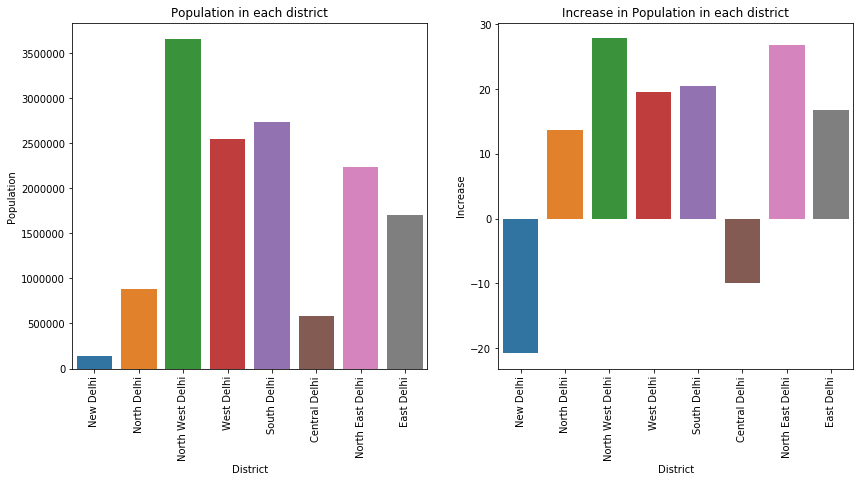

In [20]:
#plotting the graph District vs Population using seaborn barplots.
fig=plt.figure(figsize=(14,14))
ax1=plt.subplot(221)
ax1=plt.xticks(rotation=90)
ax1=sns.barplot(x="District",y="Population",data=result)
ax1=plt.title("Population in each district")

#plotting the graph District vs Increase in Population using seaborn barplots.
ax2 = plt.subplot(222)
ax2 =plt.xticks(rotation=90)
ax2 = sns.barplot(x="District", y="Increase", data=result)
ax2 = plt.title('Increase in Population in each district')


- The Maximum population is of "North-west Delhi" having Headquarters at "__Kanjhawala__"
- During the years, The population has grown much in the same "North west delhi" while in some places like "Central Delhi" and "North Delhi", it has reduced.

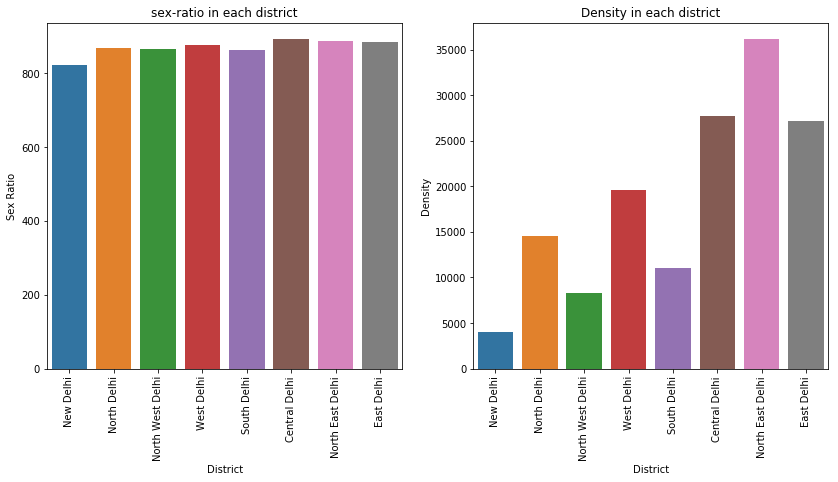

In [21]:
#plotting the graph District vs Sex Ratio using seaborn barplots
fig=plt.figure(figsize=(14,14))
ax3 = plt.subplot(221)
ax3 = plt.xticks(rotation=90)
ax3 = sns.barplot(x="District", y="Sex Ratio", data=result)
ax3 = plt.title('sex-ratio in each district')

#plotting the graph District vs Density using seaborn barplots
ax4 =plt.subplot(222)
ax4 =plt.xticks(rotation=90)
ax4 =sns.barplot(x="District",y="Density", data=result)
ax4 =plt.title("Density in each district")

- The sex-ratio is almost equal in all districts and doesnot matters much.
- While the density (total number of people per land area) of "North East Delhi" having Headquarter:"__Nand Nagri__" is the highest.

#### Getting Latitudes and Longitudes

In obtaining the location data of the Headquarters of the Districts, the Geocoder package is used with the arcgis_geocoder to obtain the latitude and longitude of the needed locations.

In [22]:
# Geocoder starts here
# Defining a function to use --> get_latlng()
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{},New delhi, India'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

In [23]:
# Applying it to our dataframe:
start = time.time()

Headquarter = df2['Headquarter']    
coordinates = [get_latlng(Headquarter) for Headquarter in Headquarter.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  19.546118021011353 seconds


Then we proceed to store the Headquarter data - latitude and longitude as follows. The obtained coordinates are then joined to result dataframe to create new data frame.

In [24]:
df_delhi = df2

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_delhi['Latitude'] = df_coordinates['Latitude']
df_delhi['Longitude'] = df_coordinates['Longitude']

In [25]:
df_delhi

,District,Headquarter,Latitude,Longitude
0,New Delhi,Connaught Place,28.633960,77.219790
1,North Delhi,Alipur,28.798050,77.144250
2,North West Delhi,Kanjhawala,28.705794,77.000791
3,West Delhi,Rajouri Garden,28.645620,77.122090
4,South West Delhi,Dwarka,28.589950,77.040070
5,South Delhi,Saket,28.524090,77.206760
6,Central Delhi,Daryaganj,28.628310,77.247270
7,North East Delhi,Nand Nagri,28.696690,77.303880
8,East Delhi,Preet Vihar,28.639060,77.295920


The resultant dataframe is then stored as a csv file.

In [26]:
df_delhi.to_csv('DelhiHeadquarterCoordinates.csv', index = False)

### 3.2 Map Visualization

Using the geopy library, the latitude and longitude values of London is obtained.

In [27]:
address = 'Delhi,India'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Delhi are 28.6517178, 77.2219388.


The folium library is then used to obtain the coordinates

In [28]:
map_1 = folium.Map(location=[latitude, longitude], zoom_start=10)

The Headquarters are then superimposed on top as shown below, still using the foliumlibrary.


In [29]:
# add markers to map
for lat, lng, neighborhood in zip(df_delhi['Latitude'],df_delhi['Longitude'],df_delhi['Headquarter']):
    label = '{}'.format(Headquarter)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_1)  
    
map_1

#### FourSquare API

To use the Foursquare API, we define the Foursquare Credentials and Version as shown below:

Please note that due to privacy, the personal Foursquare Credential has been stored in a .json <fsquarecredential.json> and called appropriately as shown below:

In [30]:
import json
filename = r'C:\Users\Sadhana\fsquarecredential.json'
with open(filename) as f:
    data = json.load(f)

In [31]:
CLIENT_ID = data['Client_Id']["0"] # your Foursquare ID
CLIENT_SECRET = data['Client_Secret']["0"] # your Foursquare Secret
VERSION = data['Version']["0"] # Foursquare API version

# 3.METHODOLOGY

### 3.1 Data Exploration

The Highly populated area that we observed was: __Kanjhawala__ of North West Delhi. We will try to explore it first.

In [32]:
df_delhi

,District,Headquarter,Latitude,Longitude
0,New Delhi,Connaught Place,28.633960,77.219790
1,North Delhi,Alipur,28.798050,77.144250
2,North West Delhi,Kanjhawala,28.705794,77.000791
3,West Delhi,Rajouri Garden,28.645620,77.122090
4,South West Delhi,Dwarka,28.589950,77.040070
5,South Delhi,Saket,28.524090,77.206760
6,Central Delhi,Daryaganj,28.628310,77.247270
7,North East Delhi,Nand Nagri,28.696690,77.303880
8,East Delhi,Preet Vihar,28.639060,77.295920


In [33]:
df_delhi.loc[2, 'Headquarter']

'Kanjhawala'

In [34]:
latitude = df_delhi.loc[2, 'Latitude'] #  latitude value
longitude = df_delhi.loc[2, 'Longitude'] #  longitude value

name = df_delhi.loc[2, 'Headquarter'] # headquarter name

print('Latitude and longitude values of {} are {}, {}.'.format(name, latitude,longitude))

Latitude and longitude values of Kanjhawala are 28.70579374824249, 77.00079144605195.


Let's explore the top 100 venues that are within a 1000 metres radius of Kanjhawala.

And then, let's create the GET request URL, and then the url is named.

In [35]:
# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=RPJBODOHKYTAX3W2B5EFQMV0PARHKJXX0WM2DDWWU3EKPAXF&client_secret=21VUJAYH2AILGB1PEJ0OVBE2PQ3D04CZJFVIQKO5UYBXCO2O&v=20180605&ll=28.70579374824249,77.00079144605195&radius=1000&limit=100'

Then, send the GET request and examine the results

In [36]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d073758f594df1b1bdb0454'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Mundka',
  'headerFullLocation': 'Mundka, Delhi',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 0,
  'suggestedBounds': {'ne': {'lat': 28.714793757242496,
    'lng': 77.01103341338069},
   'sw': {'lat': 28.69679373924248, 'lng': 76.99054947872321}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': []}]}}

Despite being the most populated area of Delhi, there were no nearby venues found within 1000 metres of area.

We will consider all the districts and lets find out with each Headquarter,which is best for opening a Restaurant

## The Battle of Neighborhood Begins 

To Get the __multiple venues__ for all headquarters, the function getNearbyVenues is used and it's created to repeat the same process for all Headquarters.

In [37]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Headquarter', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The created function - getNearbyVenues is then used on each Headquarter. And creates a new dataframe called Delhi_venues.

In [38]:
Delhi_venues = getNearbyVenues(names=df_delhi['Headquarter'],
                                   latitudes=df_delhi['Latitude'],
                                   longitudes=df_delhi['Longitude']
                                  )

Connaught Place
Alipur
Kanjhawala
Rajouri Garden
Dwarka
Saket
Daryaganj
Nand Nagri
Preet Vihar


In [39]:
Delhi_venues.shape

(193, 7)

In [40]:
Delhi_venues

,Headquarter,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Connaught Place,28.63396,77.21979,Naturals Ice Cream,28.634455,77.222139,Ice Cream Shop
1,Connaught Place,28.63396,77.21979,Connaught Place | कनॉट प्लेस (Connaught Place),28.632731,77.220018,Plaza
2,Connaught Place,28.63396,77.21979,Sagar Ratna,28.635487,77.220650,Indian Restaurant
3,Connaught Place,28.63396,77.21979,Wenger's,28.633412,77.218292,Bakery
4,Connaught Place,28.63396,77.21979,Starbucks Coffee,28.632011,77.217731,Coffee Shop
5,Connaught Place,28.63396,77.21979,Odeon Social,28.634414,77.220936,Café
6,Connaught Place,28.63396,77.21979,Khan Chacha | खान चाचा | خان چاچا,28.634202,77.220780,Indian Restaurant
7,Connaught Place,28.63396,77.21979,Route 04,28.634890,77.220225,Bar
8,Connaught Place,28.63396,77.21979,Nizam's Kathi Kabab | निजा़म काठी कबाब,28.634858,77.219462,Indian Restaurant
9,Connaught Place,28.63396,77.21979,Farzi Cafe,28.632581,77.221125,Molecular Gastronomy Restaurant


We will only consider all Restaurants from the Delhi_venues.

In [41]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

Delhi_only_Restaurant = Delhi_venues[Delhi_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
Delhi_only_Restaurant.index = np.arange(1, len(Delhi_only_Restaurant)+1)
print ("Shape of the Data-Frame with Venue Category only Restaurant: ", Delhi_only_Restaurant.shape)
Delhi_only_Restaurant

Shape of the Data-Frame with Venue Category only Restaurant:  (55, 7)


,Headquarter,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Connaught Place,28.63396,77.21979,Sagar Ratna,28.635487,77.220650,Indian Restaurant
2,Connaught Place,28.63396,77.21979,Khan Chacha | खान चाचा | خان چاچا,28.634202,77.220780,Indian Restaurant
3,Connaught Place,28.63396,77.21979,Nizam's Kathi Kabab | निजा़म काठी कबाब,28.634858,77.219462,Indian Restaurant
4,Connaught Place,28.63396,77.21979,Farzi Cafe,28.632581,77.221125,Molecular Gastronomy Restaurant
5,Connaught Place,28.63396,77.21979,United Coffee House,28.632477,77.221120,Indian Restaurant
6,Connaught Place,28.63396,77.21979,HOTEL SARAVANA BHAVAN,28.632319,77.216445,South Indian Restaurant
7,Connaught Place,28.63396,77.21979,Rajdhani Thali,28.629999,77.220401,Indian Restaurant
8,Connaught Place,28.63396,77.21979,Pind Balluchi,28.630318,77.217600,North Indian Restaurant
9,Connaught Place,28.63396,77.21979,Panchayat Paan Parlour,28.634073,77.222645,Indian Restaurant
10,Connaught Place,28.63396,77.21979,Nando's,28.630947,77.219721,Portuguese Restaurant


In [42]:
Delhi_only_Restaurant.groupby('Headquarter').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Headquarter,,,,,,
Connaught Place,31,31,31,31,31,31
Dwarka,6,6,6,6,6,6
Nand Nagri,1,1,1,1,1,1
Preet Vihar,4,4,4,4,4,4
Rajouri Garden,10,10,10,10,10,10
Saket,3,3,3,3,3,3


Here, We observe that the number of Restaurants are located in Connaught Place.

Lets, Observe all the headquarters having restaurants superimposed on a map

In [43]:
## Show in Map the Top Rated Restaruants in the Headquarters

map2 = folium.Map(location=[latitude,longitude], zoom_start=11, tiles="openstreetmap")

# set color scheme for the Venues based on the Major Headquarters
Headquarter = ['Kanjhawala', 'Saket', 'Rajouri Garden', 'Nand Nagri',"Preet Vihar","Alipur",
               'Daryanganj',"Connaught Place","Dwarka"]
,
x = np.arange(len(Headquarter))

rainbow = ["#5F021F","#34DDDD","#FF0080","#FF9933","#00FF00","#663399",'#FFFF00',"#028482","#ffa500"]

# add markers to the map
# markers_colors = []
for lat, lon, poi, res in zip(Delhi_only_Restaurant ['Venue Latitude'], 
                                  Delhi_only_Restaurant ['Venue Longitude'], 
                                  Delhi_only_Restaurant ['Venue Category'], 
                                  Delhi_only_Restaurant ['Headquarter']):
    label = folium.Popup(str(poi) + ' ' + str(res), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[Headquarter.index(res)-1],
        fill=True,
        fill_color=rainbow[Headquarter.index(res)-1],
        fill_opacity=0.3).add_to(map2)
       
map2

The next step is to check how many unique categories can be returned for the venues. See as follows:

In [44]:
print('There are {} uniques categories.'.format(len(Delhi_venues['Venue Category'].unique())))

There are 77 uniques categories.


In [45]:
Delhi_unique_count=Delhi_venues['Venue Category'].value_counts().to_frame(name="Count")
Delhi_unique_count

,Count
Indian Restaurant,21
Hotel,14
Café,14
Fast Food Restaurant,7
Coffee Shop,7
Chinese Restaurant,6
Bakery,5
Shopping Mall,5
Pizza Place,5
Bar,4


## 3.2 Clustering

For this section, the venues will be clustered based on the processed data obtained above.

###### one hot encoding

In [46]:
# one hot encoding 
Delhi_one_hot = pd.get_dummies(Delhi_venues[['Venue Category']], prefix="", prefix_sep="")

Then the headquartercolumn is added back to the dataframe.

In [47]:
# add Headquarter column back to dataframe
Delhi_one_hot['Headquarter'] =Delhi_venues['Headquarter'] 

Some re-arrangement - move the new Headquarter column to the first column.

In [48]:
# move Headquarter column to the first column
fixed_columns = [Delhi_one_hot.columns[-1]] + list(Delhi_one_hot.columns[:-1])
Delhi_one_hot = Delhi_one_hot[fixed_columns]

Therefore, the new one hot encoded dataframe is:

In [49]:
Delhi_one_hot

,Headquarter,ATM,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Garden,Bistro,Burger Joint,Bus Station,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Truck,Garden,Gastropub,Gourmet Shop,Historic Site,Hookah Bar,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Market,Mediterranean Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Multiplex,Music Venue,Nightclub,North Indian Restaurant,Park,Pizza Place,Platform,Plaza,Portuguese Restaurant,Pub,Resort,Restaurant,Road,Salon / Barbershop,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Souvenir Shop,Stadium,Tea Room,Tibetan Restaurant,Train Station,Yoga Studio
0,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Connaught Place,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Connaught Place,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Connaught Place,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
Delhi_one_hot.shape

(193, 78)

#### Regrouping and category statistics

In [51]:
Delhi_Grouped = Delhi_one_hot.groupby('Headquarter').mean().reset_index()
Delhi_Grouped.index = np.arange(1, len(Delhi_Grouped)+1)
Delhi_Grouped

,Headquarter,ATM,American Restaurant,Arcade,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Garden,Bistro,Burger Joint,Bus Station,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food & Drink Shop,Food Truck,Garden,Gastropub,Gourmet Shop,Historic Site,Hookah Bar,Hotel,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Market,Mediterranean Restaurant,Miscellaneous Shop,Molecular Gastronomy Restaurant,Multiplex,Music Venue,Nightclub,North Indian Restaurant,Park,Pizza Place,Platform,Plaza,Portuguese Restaurant,Pub,Resort,Restaurant,Road,Salon / Barbershop,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Souvenir Shop,Stadium,Tea Room,Tibetan Restaurant,Train Station,Yoga Studio
1,Alipur,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Connaught Place,0.00,0.000000,0.000000,0.000000,0.023256,0.000000,0.023256,0.011628,0.046512,0.011628,0.011628,0.000000,0.00,0.093023,0.034884,0.011628,0.046512,0.000,0.023256,0.000000,0.011628,0.011628,0.011628,0.000000,0.000000,0.0,0.000000,0.034884,0.011628,0.011628,0.000,0.000,0.011628,0.000,0.011628,0.000,0.093023,0.011628,0.011628,0.139535,0.011628,0.023256,0.011628,0.011628,0.000,0.000000,0.011628,0.034884,0.000000,0.011628,0.011628,0.011628,0.000000,0.000,0.011628,0.011628,0.000000,0.000000,0.011628,0.011628,0.011628,0.011628,0.00,0.000000,0.011628,0.011628,0.000000,0.000000,0.00,0.000,0.023256,0.011628,0.000000,0.011628,0.011628,0.000000,0.000000
3,Daryaganj,0.00,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000
4,Dwarka,0.00,0.058824,0.000000,0.000000,0.058824,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.117647,0.000000,0.000,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.000000,0.0,0.058824,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.058824,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.058824,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.117647,0.000000,0.000000,0.000000,0.117647,0.00,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Nand Nagri,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,

In [52]:
print("Before One-hot encoding:", df2.shape)
print("After One-hot encoding:", Delhi_Grouped .shape)

Before One-hot encoding: (9, 4)
After One-hot encoding: (8, 78)


Grouping of each Neighbourhoods with 5 common venues:

In [53]:
num_top_venues = 5

for places in Delhi_Grouped['Headquarter']:
    print("%%%%%%%%%"+places+"%%%%%%%%")
    temp = Delhi_Grouped[Delhi_Grouped['Headquarter'] == places].T.reset_index()
    temp.columns = ['Venue','Freq']
    temp = temp.iloc[1:]
    temp['Freq'] = temp['Freq'].astype(float)
    temp = temp.round({'Freq': 2})
    print(temp.sort_values('Freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

%%%%%%%%%Alipur%%%%%%%%
         Venue  Freq
0         Farm  0.50
1       Resort  0.25
2  Bus Station  0.25
3          ATM  0.00
4  Pizza Place  0.00


%%%%%%%%%Connaught Place%%%%%%%%
               Venue  Freq
0  Indian Restaurant  0.14
1              Hotel  0.09
2               Café  0.09
3        Coffee Shop  0.05
4                Bar  0.05


%%%%%%%%%Daryaganj%%%%%%%%
          Venue  Freq
0         Plaza  0.17
1       Stadium  0.17
2         Hotel  0.17
3  Burger Joint  0.17
4   Art Gallery  0.17


%%%%%%%%%Dwarka%%%%%%%%
               Venue  Freq
0      Shopping Mall  0.12
1         Restaurant  0.12
2  Indian Restaurant  0.12
3     Clothing Store  0.12
4              Hotel  0.06


%%%%%%%%%Nand Nagri%%%%%%%%
               Venue  Freq
0                ATM  0.25
1        Snack Place  0.25
2         Smoke Shop  0.25
3  Indian Restaurant  0.25
4          Jazz Club  0.00


%%%%%%%%%Preet Vihar%%%%%%%%
                      Venue  Freq
0               Pizza Place  0.13
1            

#### Creating new dataframe

Putting the common venues into pandas dataframe, the following return_most_common_venues is used to sort the venues in descending order.

In [54]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Then we create a new panda dataframe with 10 most common venues as shown below:

In [55]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Headquarter']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Top_venues_sorted = pd.DataFrame(columns=columns)
Top_venues_sorted['Headquarter'] = Delhi_Grouped['Headquarter']

for ind in np.arange(Delhi_Grouped.shape[0]):
    Top_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Delhi_Grouped.iloc[ind, :], num_top_venues)

In [56]:
Top_venues_sorted

,Headquarter,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alipur,Farm,Resort,Bus Station,Yoga Studio,Department Store,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market
2,Connaught Place,Indian Restaurant,Café,Hotel,Coffee Shop,Bar,Lounge,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,BBQ Joint
3,Daryaganj,Burger Joint,Train Station,Hotel,Stadium,Art Gallery,Plaza,Yoga Studio,Donut Shop,Electronics Store,Falafel Restaurant
4,Dwarka,Indian Restaurant,Shopping Mall,Clothing Store,Restaurant,Hotel,Farmers Market,American Restaurant,Department Store,Electronics Store,Asian Restaurant
5,Nand Nagri,ATM,Indian Restaurant,Snack Place,Smoke Shop,Fast Food Restaurant,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant
6,Preet Vihar,Pizza Place,Yoga Studio,Shopping Mall,Mediterranean Restaurant,Chinese Restaurant,Café,Fast Food Restaurant,Dessert Shop,Shop & Service,Multiplex
7,Rajouri Garden,Indian Restaurant,Fast Food Restaurant,Café,Bakery,Market,Shopping Mall,Donut Shop,Cosmetics Shop,Department Store,Light Rail Station
8,Saket,Hotel,Coffee Shop,Park,Pizza Place,Café,Multiplex,Electronics Store,Indian Restaurant,Athletics & Sports,Falafel Restaurant


In [57]:
Delhi_grouped_clustering = Delhi_Grouped.drop('Headquarter', 1)

#### Clustering Neighborhoods using K-means

The next thing to do now, is to create clusters of the neighbourhood using the k-means to cluster the Headquarter into 3 clusters.

In [58]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(Delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 1, 1, 1, 0, 1, 1, 1])

Now creating a new dataframe that includes the clusters as well as the top 10 venues for each Headquarter.

In [59]:
# add clustering labels
Top_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [60]:
Delhi_merged = df2

In [61]:
Delhi_merged

,District,Headquarter,Latitude,Longitude
0,New Delhi,Connaught Place,28.633960,77.219790
1,North Delhi,Alipur,28.798050,77.144250
2,North West Delhi,Kanjhawala,28.705794,77.000791
3,West Delhi,Rajouri Garden,28.645620,77.122090
4,South West Delhi,Dwarka,28.589950,77.040070
5,South Delhi,Saket,28.524090,77.206760
6,Central Delhi,Daryaganj,28.628310,77.247270
7,North East Delhi,Nand Nagri,28.696690,77.303880
8,East Delhi,Preet Vihar,28.639060,77.295920


In [62]:
# match/merge SE London data with latitude/longitude for each neighborhood
Delhi_merged_latlong = Delhi_merged.join(Top_venues_sorted.set_index('Headquarter'), on = 'Headquarter')

In [63]:
Delhi_merged_latlong

,District,Headquarter,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New Delhi,Connaught Place,28.633960,77.219790,1.0,Indian Restaurant,Café,Hotel,Coffee Shop,Bar,Lounge,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,BBQ Joint
1,North Delhi,Alipur,28.798050,77.144250,2.0,Farm,Resort,Bus Station,Yoga Studio,Department Store,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market
2,North West Delhi,Kanjhawala,28.705794,77.000791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,West Delhi,Rajouri Garden,28.645620,77.122090,1.0,Indian Restaurant,Fast Food Restaurant,Café,Bakery,Market,Shopping Mall,Donut Shop,Cosmetics Shop,Department Store,Light Rail Station
4,South West Delhi,Dwarka,28.589950,77.040070,1.0,Indian Restaurant,Shopping Mall,Clothing Store,Restaurant,Hotel,Farmers Market,American Restaurant,Department Store,Electronics Store,Asian Restaurant
5,South Delhi,Saket,28.524090,77.206760,1.0,Hotel,Coffee Shop,Park,Pizza Place,Café,Multiplex,Electronics Store,Indian Restaurant,Athletics & Sports,Falafel Restaurant
6,Central Delhi,Daryaganj,28.628310,77.247270,1.0,Burger Joint,Train Station,Hotel,Stadium,Art Gallery,Plaza,Yoga Studio,Donut Shop,Electronics Store,Falafel Restaurant
7,North East Delhi,Nand Nagri,28.696690,77.303880,0.0,ATM,Indian Restaurant,Snack Place,Smoke Shop,Fast Food Restaurant,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant
8,East Delhi,Preet Vihar,28.639060,77.295920,1.0,Pizza Place,Yoga Studio,Shopping Mall,Mediterranean Restaurant,Chinese Restaurant,Café,Fast Food Restaurant,Dessert Shop,Shop & Service,Multiplex


In [64]:
Delhi_clusters = Delhi_merged_latlong
Delhi_clusters.fillna(0, inplace=True)
Delhi_clusters["Cluster Labels"]=Delhi_clusters["Cluster Labels"].astype(int)

In [65]:
Delhi_clusters

,District,Headquarter,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New Delhi,Connaught Place,28.633960,77.219790,1,Indian Restaurant,Café,Hotel,Coffee Shop,Bar,Lounge,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,BBQ Joint
1,North Delhi,Alipur,28.798050,77.144250,2,Farm,Resort,Bus Station,Yoga Studio,Department Store,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market
2,North West Delhi,Kanjhawala,28.705794,77.000791,0,0,0,0,0,0,0,0,0,0,0
3,West Delhi,Rajouri Garden,28.645620,77.122090,1,Indian Restaurant,Fast Food Restaurant,Café,Bakery,Market,Shopping Mall,Donut Shop,Cosmetics Shop,Department Store,Light Rail Station
4,South West Delhi,Dwarka,28.589950,77.040070,1,Indian Restaurant,Shopping Mall,Clothing Store,Restaurant,Hotel,Farmers Market,American Restaurant,Department Store,Electronics Store,Asian Restaurant
5,South Delhi,Saket,28.524090,77.206760,1,Hotel,Coffee Shop,Park,Pizza Place,Café,Multiplex,Electronics Store,Indian Restaurant,Athletics & Sports,Falafel Restaurant
6,Central Delhi,Daryaganj,28.628310,77.247270,1,Burger Joint,Train Station,Hotel,Stadium,Art Gallery,Plaza,Yoga Studio,Donut Shop,Electronics Store,Falafel Restaurant
7,North East Delhi,Nand Nagri,28.696690,77.303880,0,ATM,Indian Restaurant,Snack Place,Smoke Shop,Fast Food Restaurant,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant
8,East Delhi,Preet Vihar,28.639060,77.295920,1,Pizza Place,Yoga Studio,Shopping Mall,Mediterranean Restaurant,Chinese Restaurant,Café,Fast Food Restaurant,Dessert Shop,Shop & Service,Multiplex


### Optimal Number of Clusters for K-means

To get the optimal number of clusters to be used for the K-mean, there are a number ways possible for the evaluation. Therefore, in this task, the following are used:

- Elbow (Criterion) Method 
- Silhouette Coefficient

- __Elbow Method__

The elbow method is used to solve the problem of selecting k. Interestingly, the elbow method is not perfect either but it gives significant insight that is perhaps not top optimal but sub-optimal to choosing the optimal number of clusters by fitting the model with a range of values for k.

The approach for this is to run the k-means clustering for a range of value k and for each value of k, the Sum of the Squared Errors (SSE) is calculated., calculate sum of squared errors (SSE). When this is done, a plot of k and the corresponding SSEs are then made. At the elbow (just like arm), that is where the optimal value of k is. And that will be the number of clusters to be used. The whole idea is to have minimum SSE.

In [66]:
%matplotlib inline
import matplotlib
import numpy as np

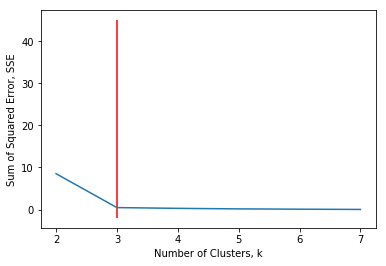

In [68]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 8):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 500).fit(Delhi_grouped_clustering)
    Delhi_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

- __Silhouette Coefficient__

To find the optimal value of the number of clusters, k, the number of clusters is iterated corresponding Silhouette Coefficientis calculated for each of the k-values used. The highest Silhouette Coefficient gives the best match to its own cluster. Please see below:

In [69]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for n_cluster2 in range(2, 8):
    kmeans2 = KMeans(n_clusters = n_cluster2, random_state = 0).fit(Delhi_grouped_clustering)
    label2 = kmeans2.labels_
    sil_coeff = silhouette_score(Delhi_grouped_clustering, label2, metric = 'euclidean')
    print("Where n_clusters = {}, the Silhouette Coefficient is {}".format(n_cluster2, sil_coeff))

Where n_clusters = 2, the Silhouette Coefficient is 0.5367173084394803
Where n_clusters = 3, the Silhouette Coefficient is 0.44766890975627105
Where n_clusters = 4, the Silhouette Coefficient is 0.3370626632738435
Where n_clusters = 5, the Silhouette Coefficient is 0.2054949992365766
Where n_clusters = 6, the Silhouette Coefficient is 0.22613411581165366
Where n_clusters = 7, the Silhouette Coefficient is 0.20775915051768076


From the result, the high the n_clusters the better the silhouette coefficient. For this project, a cluster value of 3 will be used.

In [70]:
Delhi_clusters.columns

Index(['District', 'Headquarter', 'Latitude', 'Longitude', 'Cluster Labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

#### Visualizing the resulting clusters

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Delhi_clusters['Latitude'], Delhi_clusters['Longitude'], Delhi_clusters['Headquarter'], Delhi_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)


#### Cluster1

In [72]:
Delhi_clusters.loc[Delhi_clusters['Cluster Labels'] == 0, Delhi_clusters.columns[[1] + list(range(5, Delhi_clusters.shape[1]))]]

,Headquarter,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Kanjhawala,0,0,0,0,0,0,0,0,0,0
7,Nand Nagri,ATM,Indian Restaurant,Snack Place,Smoke Shop,Fast Food Restaurant,Dessert Shop,Diner,Donut Shop,Electronics Store,Falafel Restaurant


#### Cluster2

In [73]:
Delhi_clusters.loc[Delhi_clusters['Cluster Labels'] == 1, Delhi_clusters.columns[[1] + list(range(5, Delhi_clusters.shape[1]))]]

,Headquarter,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Connaught Place,Indian Restaurant,Café,Hotel,Coffee Shop,Bar,Lounge,Chinese Restaurant,Fast Food Restaurant,Italian Restaurant,BBQ Joint
3,Rajouri Garden,Indian Restaurant,Fast Food Restaurant,Café,Bakery,Market,Shopping Mall,Donut Shop,Cosmetics Shop,Department Store,Light Rail Station
4,Dwarka,Indian Restaurant,Shopping Mall,Clothing Store,Restaurant,Hotel,Farmers Market,American Restaurant,Department Store,Electronics Store,Asian Restaurant
5,Saket,Hotel,Coffee Shop,Park,Pizza Place,Café,Multiplex,Electronics Store,Indian Restaurant,Athletics & Sports,Falafel Restaurant
6,Daryaganj,Burger Joint,Train Station,Hotel,Stadium,Art Gallery,Plaza,Yoga Studio,Donut Shop,Electronics Store,Falafel Restaurant
8,Preet Vihar,Pizza Place,Yoga Studio,Shopping Mall,Mediterranean Restaurant,Chinese Restaurant,Café,Fast Food Restaurant,Dessert Shop,Shop & Service,Multiplex


#### Cluster3

In [74]:
Delhi_clusters.loc[Delhi_clusters['Cluster Labels'] == 2, Delhi_clusters.columns[[1] + list(range(5, Delhi_clusters.shape[1]))]]

,Headquarter,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alipur,Farm,Resort,Bus Station,Yoga Studio,Department Store,Diner,Donut Shop,Electronics Store,Falafel Restaurant,Farmers Market


# 4.RESULT

The following are the highlights obtained from above 3 clusters and the data analysis:

- It is surprising to know that despite being the most populated area of delhi, we are not able to find any common venue near Kanjhawala.
- Out of the all districts of Delhi, Indian Restaurant is found in the first venue category.
- There are number of eating points in all districts than any other venues. 
- Although the clusters have variation, but the predominance of Indian restaurant was found 50%
- The number of Indian Restaurants were found at "Connaught Place" followed by hotels and cafe.

# 5.DISCUSSION AND CONCLUSION

It will be beneficial to open a restaurant at __Alipur__, __North delhi__ as this will give least competition and doesnot have any restaurants nearby.
We were not able to find  any venues nearby Kanjhawala , the reason is that Khanjawala is a village and has very less amenities within 1kms. 

Some drawback of these analyses is that  clustering is done on only the most common venues which are obtained using four square location. Also, we have taken into consideration  one city under each district .
Also the result can vary if we use other clustering techniques like DBSCAN.

In conclusion, this project would have had better results if there were more data in terms of crime data within the area, price of the land, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls).
Also, getting the ratings and feedbacks of the current restaurants within the clusters would have helped in providing more insight into the best location.